# import

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
#import xgboost as xgb
import pickle
from pyvino.detector.detector import DetectorHumanPose
import sys
sys.path.append('..')
from actrec.util import *

import matplotlib as mpl

 # path

In [62]:
notebook_name = os.path.basename(os.getcwd())
timestamp = notebook_name.split('_')[1]
timestamp

'07'

In [63]:
path_movie_dir = '../data/movie/fps30_mask/'
path_save_dir = os.path.join('../data/05_Train/', timestamp)
if not os.path.exists(path_save_dir):
    os.makedirs(path_save_dir)
path_train_file = os.path.join(path_save_dir, 'train.csv')
path_model_file = os.path.join(path_save_dir, 'model.pkl')

In [64]:
path_label_name_file = '../data/labels/labels_num.csv'
path_action_dir = os.path.join('../data/01_DataProcessing/', timestamp)
path_point_dir = os.path.join('../data/02_GetPoints/', timestamp)
path_split_dir = os.path.join('../data/04_Split/', timestamp)

path_train_file_dir = os.path.join(path_split_dir, 'train')
path_test_file_dir = os.path.join(path_split_dir, 'test')
# path_model_dir = '../data/05_train/'

In [65]:
file_names = ['forehand', 'backhand', 'foreslice', 'backslice']
# file_names = ['forehand']
movie_names = [file_name + '.mp4' for file_name in file_names]
points_file_names = [file_name + '.csv' for file_name in file_names]

# data

In [66]:
objective = 'action_gt_num'

# データ加工

## moving average

In [67]:
features = ['RShoulder',  'RElbow',  'RWrist',
            'LShoulder',  'LElbow',  'LWrist']

In [68]:
target_columns = []
for feature in features:
    target_columns.append(feature + '_x')
    target_columns.append(feature + '_y')

target_columns = ['RShoulder_x', 'RShoulder_y', 'RElbow_x', 'RElbow_y', 'RWrist_x', 'RWrist_y', 
                         'LShoulder_x', 'LShoulder_y', 'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y']

## 30 frames as one data

In [69]:
num = 0
path_file = os.path.join(path_train_file_dir, points_file_names[num])
data_df = pd.read_csv(path_file, index_col='frame_num')
# data_df = pd.read_csv(path_file, index_col='frame_num')

In [70]:
frame_length = 15
X = data_df.drop(columns=[objective])
one_hot_columns_name = generate_col_names(X)

In [71]:
points_file_names[0]

'forehand.csv'

In [72]:
points_file_name = points_file_names[0]
path_file = os.path.join(path_train_file_dir, points_file_name)
data_df = pd.read_csv(path_file, index_col='frame_num')

In [73]:
col_names = generate_col_names(X)

In [74]:
units_df = None
new_data_df = None
for num, points_file_name in enumerate(points_file_names):
    print(points_file_name)
    path_file = os.path.join(path_train_file_dir, points_file_name)
    data_df = pd.read_csv(path_file, index_col='frame_num')
    units_df = None
    for idx in data_df.index[frame_length:len(data_df)]:
        unit_df = data_df[idx - frame_length: idx]
        y = unit_df[objective]
        X = unit_df.drop(columns=[objective]).loc[:, target_columns]
        unit_df = flatten_data(X, y, objective)
        if units_df is None:
            units_df = unit_df
        else:
            units_df = pd.concat([units_df, unit_df], axis=0, sort=False)
    path_save_file = os.path.join(path_save_dir, points_file_name)
    units_df.to_csv(path_save_file)
    if new_data_df is None:
        new_data_df = units_df
    else:
        new_data_df = pd.concat([new_data_df, units_df], axis=0, sort=False)
train_data_df = new_data_df.copy()
train_data_df.to_csv(path_train_file)

forehand.csv
backhand.csv
foreslice.csv
backslice.csv


In [75]:
train_data_df = new_data_df.copy()

In [76]:
train_data_df.groupby('action_gt_num').count()

,RShoulder_x_-14,RShoulder_y_-14,RElbow_x_-14,RElbow_y_-14,RWrist_x_-14,RWrist_y_-14,LShoulder_x_-14,LShoulder_y_-14,LElbow_x_-14,LElbow_y_-14,...,RElbow_x_0,RElbow_y_0,RWrist_x_0,RWrist_y_0,LShoulder_x_0,LShoulder_y_0,LElbow_x_0,LElbow_y_0,LWrist_x_0,LWrist_y_0
action_gt_num,,,,,,,,,,,,,,,,,,,,,
0,9656,9656,9204,9204,8277,8277,9451,9451,7522,7522,...,9266,9266,8509,8509,9461,9461,8029,8029,7623,7623
1,1482,1482,1473,1473,1478,1478,1452,1452,1381,1381,...,1404,1404,1266,1266,1480,1480,1282,1282,1281,1281
2,1419,1419,1357,1357,1111,1111,1420,1420,1409,1409,...,1373,1373,1129,1129,1386,1386,1133,1133,1076,1076
3,1114,1114,1104,1104,1111,1111,1085,1085,905,905,...,1082,1082,1077,1077,1111,1111,816,816,887,887
4,814,814,719,719,582,582,834,834,818,818,...,766,766,608,608,845,845,821,821,722,722


## 学習データ

In [77]:
# remove backhand
# train_data_df = train_data_df[train_data_df['action_gt_num']!=2]

In [78]:
X_train_data_df = train_data_df.drop([objective], axis=1)
y_train_data_df = train_data_df[objective]

In [95]:
train_data_df['dummy'] = 1
train_data_df.groupby(objective).count()['dummy']

action_gt_num
0    11384
1     1482
2     1430
3     1118
4      988
Name: dummy, dtype: int64

## data for lgb

In [79]:
lgb_train = lgb.Dataset(X_train_data_df, y_train_data_df)

# 学習

In [80]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 5,
        'learning_rate': 0.01,
        'num_leaves': 64,
        'min_data_in_leaf': 1,
        'num_iteration': 1000,
        'early_stopping_rounds': 50,
        'verbose': 1,
        'num_threads': 4
}

In [81]:
cv_results = lgb.cv(params, lgb_train, nfold=4)
cv_logloss = cv_results['multi_logloss-mean']
round_n = np.arange(len(cv_logloss))

/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


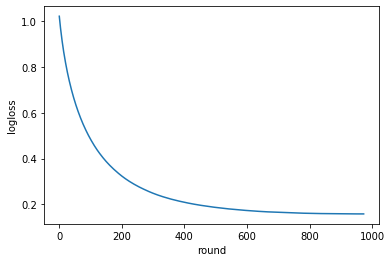

In [82]:
plt.xlabel('round')
plt.ylabel('logloss')
plt.plot(round_n, cv_logloss)
plt.show()

In [83]:
params.pop('early_stopping_rounds')
best_num_round = np.argmin(cv_logloss)
params['num_iteration'] = best_num_round
print(best_num_round)

973


In [84]:
gbm = lgb.train(params, lgb_train)

/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## モデル保存

In [85]:
path_model_file = os.path.join(path_save_dir, 'model.pkl')

In [86]:
pickle.dump(gbm, open(path_model_file, "wb"))

## モデル読み込み

In [87]:
gbm = pickle.load(open(path_model_file, "rb"))

In [88]:
feature_name_list = gbm.feature_name()